Restart cuda module after suspend by:  
`$ sudo rmmod nvidia_uvm`  
`$ sudo modprobe nvidia_uvm`

1. Test용으로 몇 장 빼둘 것. 
2. Train의 목적: -- T-type을 N개의 label로 잘 구별하는 representation vector를 구하는 것.  
3. 목적대로 train 되었는지 testset으로 확인 -- Freeze된 ResNet으로 classification을 잘 수행하는가..  
    3.1 ResNet은 아무런 train이 필요 없나? 뭔갈 해야하나? 
4. train 잘 되었다면 그 담에 뭘 할까? -- M20, Gini, Contrast등의 값을 feature vector로 변경. --> custom_morph 코드를 Train된 ResNet으로 변경. 

ToneMapping이 바뀔 때마다 ResNet의 마지막 layer 정도는 fine-tune할 수 있지 않을까? 



Gaussian blur는 1-channel에도 적용할 수 있을 것 같은데.

In [ ]:
import numpy as np
import pickle

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision
from torchvision.transforms import transforms
#from torchvision import models

import atm
import atm.simclr as simclr
import atm.simclr.resnet as models

import argparse 

from PIL import Image
from typing import Any, Callable, Optional, Tuple
from torchvision.datasets.vision import VisionDataset
from functools import partial
from astrobf.tmo import Mantiuk_Seidel


import logging
import os
import sys
import yaml

import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
#from utils import save_config_file, accuracy, save_checkpoint

In [ ]:
do_parallel = True

args = argparse.Namespace()

args.data='./datasets' 
#args.dataset_name='cifar10'
args.arch='resnet50'
args.workers=1
args.epochs=300 

if do_parallel:
    args.batch_size = 128
else:
    args.batch_size = 256

args.lr=0.02
args.weight_decay=0.0005
args.disable_cuda=False
args.fp16_precision=True
args.out_dim=10
args.log_every_n_steps=100
args.temperature=0.07
args.n_views = 2
#args.gpu_index=0
args.device='cuda' if torch.cuda.is_available() else 'cpu'

print("Using device:", args.device)

img_size =128


assert args.n_views == 2, "Only two view training is supported. Please use --n-views 2."
# check if gpu training is available
if not args.disable_cuda and torch.cuda.is_available():
    args.device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    args.device = torch.device('cpu')
    #args.gpu_index = -1




class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transform(x) for i in range(self.n_views)]
    
class TonemapImageDataset(VisionDataset):
    def __init__(self, 
                 data_array, 
                 tmo,
                 labels: Optional = None, 
                 train: bool=True,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,):
        self._array = data_array
        self._good_gids = np.array([gal['img_name'] for gal in data_array])
        self.img_labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.tmo = tmo
        self._bad_tmo=False

    def _apply_tm(self, image):
        try:
            return self.tmo(image)
        except ZeroDivisionError:
            print("division by zero. Probably bad choice of TM parameters")
            self._bad_tmo=True
            return image

    def _to_8bit(self, image):
        """
        Normalize per image (or use global min max??)
        """

        image = (image - image.min())/image.ptp()
        image *= 255
        return image.astype('uint8')        
    
    def __len__(self) -> int:
        return len(self._array)
    
    def __getitem__(self, idx: int) -> Tuple[Any, Any]:
        """
        For super
        """
        image, _segmap, weight = self._array[idx]['data']
        image[~_segmap.astype(bool)] = 0#np.nan # Is it OK to have nan?
        image[image < 0] = 0

        image = self._to_8bit(self._apply_tm(image))
        image = Image.fromarray(image)
        target = self.img_labels[idx]
        
        if self.transform is not None:
            image = self.transform(image)
            
        if self.target_transform is not None:
            target = self.target_transform(target)
            
        return image, target

    
class ContrastiveLearningDataset():
    def __init__(self):
        pass
    
    @staticmethod
    def get_simclr_pipeline_transform(size, s=1, n_channels=3):
        """Return a set of data augmentation transformations as described in the SimCLR paper."""
        color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
        data_transforms = transforms.Compose([transforms.RandomResizedCrop(size=size),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.RandomApply([color_jitter], p=0.8),
                                              transforms.RandomGrayscale(p=0.2),
                                              GaussianBlur(kernel_size=int(0.1 * size)),
                                              transforms.ToTensor()])
        if n_channels == 1:
            _transform = _transform + [transforms.Lambda(lambda x: x.mean(dim=0, keepdim=True))]
            
        return data_transforms

    def get_dataset(self, name, n_views, n_channels=3):
        return TonemapImageDataset(all_gals, partial(Mantiuk_Seidel, **tmo_params),
                                labels=cat['TT'].to_numpy(),
                                train=True, 
                                transform=ContrastiveLearningViewGenerator(
                                    self.get_simclr_pipeline_transform(img_size, n_channels=1)
                                ))




ddir = "../../tonemap/bf_data/Nair_and_Abraham_2010/"

fn = ddir + "all_gals.pickle"
all_gals = pickle.load(open(fn, "rb"))

all_gals = all_gals[1:] # Why the first galaxy image is NaN?

good_gids = np.array([gal['img_name'] for gal in all_gals])

from astrobf.utils.misc import load_Nair
cat_data = load_Nair(ddir + "catalog/table2.dat")
# pd dataframe

cat = cat_data[cat_data['ID'].isin(good_gids)]

tmo_params = {'b': 6.0,  'c': 3.96, 'dl': 9.22, 'dh': 2.45}



class ResNetSimCLR(nn.Module):

    def __init__(self, base_model, out_dim):
        super(ResNetSimCLR, self).__init__()
        self.resnet_dict = {"resnet18": models.resnet18(pretrained=False, num_classes=out_dim, num_channels=1),
                            "resnet50": models.resnet50(pretrained=False, num_classes=out_dim, num_channels=1)}

        self.backbone = self._get_basemodel(base_model)
        dim_mlp = self.backbone.fc.in_features

        # add mlp projection head
        self.backbone.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.backbone.fc)

    def _get_basemodel(self, model_name):
        try:
            model = self.resnet_dict[model_name]
        except KeyError:
            raise InvalidBackboneError(
                "Invalid backbone architecture. Check the config file and pass one of: resnet18 or resnet50")
        else:
            return model

    def forward(self, x):
        return self.backbone(x)





def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


def save_config_file(model_checkpoints_folder, args):
    if not os.path.exists(model_checkpoints_folder):
        os.makedirs(model_checkpoints_folder)
        with open(os.path.join(model_checkpoints_folder, 'config.yml'), 'w') as outfile:
            yaml.dump(args, outfile, default_flow_style=False)


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

class SimCLR(object):

    def __init__(self, *args, **kwargs):
        self.args = kwargs['args']
        self.model = kwargs['model'].to(self.args.device)
        self.optimizer = kwargs['optimizer']
        self.scheduler = kwargs['scheduler']
        self.writer = SummaryWriter()
        logging.basicConfig(filename=os.path.join(self.writer.log_dir, 'training.log'), level=logging.DEBUG)
        self.criterion = torch.nn.CrossEntropyLoss().to(self.args.device)

    def info_nce_loss(self, features):

        labels = torch.cat([torch.arange(self.args.batch_size) for i in range(self.args.n_views)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(self.args.device)

        features = F.normalize(features, dim=1)

        similarity_matrix = torch.matmul(features, features.T)
        # assert similarity_matrix.shape == (
        #     self.args.n_views * self.args.batch_size, self.args.n_views * self.args.batch_size)
        # assert similarity_matrix.shape == labels.shape

        # discard the main diagonal from both: labels and similarities matrix
        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(self.args.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
        # assert similarity_matrix.shape == labels.shape

        # select and combine multiple positives
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # select only the negatives the negatives
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.args.device)

        logits = logits / self.args.temperature
        return logits, labels

    def train(self, train_loader):

        scaler = GradScaler(enabled=self.args.fp16_precision)

        # save config file
        save_config_file(self.writer.log_dir, self.args)

        n_iter = 0
        logging.info(f"Start SimCLR training for {self.args.epochs} epochs.")
        logging.info(f"Training with gpu: {self.args.disable_cuda}.")

        for epoch_counter in range(self.args.epochs):
            for images, _ in tqdm(train_loader):
                images = torch.cat(images, dim=0)

                images = images.to(self.args.device)

                with autocast(enabled=self.args.fp16_precision):
                    features = self.model(images)
                    logits, labels = self.info_nce_loss(features)
                    loss = self.criterion(logits, labels)

                self.optimizer.zero_grad()

                scaler.scale(loss).backward()

                scaler.step(self.optimizer)
                scaler.update()

                if n_iter % self.args.log_every_n_steps == 0:
                    top1, top5 = accuracy(logits, labels, topk=(1, 5))
                    self.writer.add_scalar('loss', loss, global_step=n_iter)
                    self.writer.add_scalar('acc/top1', top1[0], global_step=n_iter)
                    self.writer.add_scalar('acc/top5', top5[0], global_step=n_iter)
                    self.writer.add_scalar('learning_rate', self.scheduler.get_lr()[0], global_step=n_iter)

                n_iter += 1

            # warmup for the first 10 epochs
            if epoch_counter >= 10:
                self.scheduler.step()
            logging.debug(f"Epoch: {epoch_counter}\tLoss: {loss}\tTop1 accuracy: {top1[0]}")

        logging.info("Training has finished.")
        # save model checkpoints
        checkpoint_name = 'checkpoint_{:04d}.pth.tar'.format(self.args.epochs)
        save_checkpoint({
            'epoch': self.args.epochs,
            'arch': self.args.arch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'batchsize': self.args.batch_size,
        }, is_best=False, filename=os.path.join(self.writer.log_dir, checkpoint_name))
        logging.info(f"Model checkpoint and metadata has been saved at {self.writer.log_dir}.")


def get_simclr_pipeline_transform(size, s=1, n_channels=3):
    """Return a set of data augmentation transformations as described in the SimCLR paper."""
    #color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
    _transforms = [transforms.RandomResizedCrop(size=size),
                  transforms.RandomHorizontalFlip(),
                  #transforms.RandomApply([color_jitter], p=0.8), <- 3 channel이어야만 사용 가능
                  #transforms.RandomGrayscale(p=0.2),
                  #GaussianBlur(kernel_size=int(0.1 * size)),
                  transforms.ToTensor()]
    if n_channels == 1:
        _transforms = _transforms + [transforms.Lambda(lambda x: x.mean(dim=0, keepdim=True))]

    return transforms.Compose(_transforms)

train_dataset = TonemapImageDataset(all_gals, partial(Mantiuk_Seidel, **tmo_params),
                                    labels=cat['TT'].to_numpy(),
                                    train=True, 
                                    transform=ContrastiveLearningViewGenerator(
                                        get_simclr_pipeline_transform(128, n_channels=1)
                                    ))


train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=True,
    num_workers=args.workers, pin_memory=True, drop_last=True)

model = ResNetSimCLR(base_model=args.arch, out_dim=args.out_dim)
if do_parallel:
    model = nn.DataParallel(model)#, output_device=1) # split works into different devices. 1 deals with the output, 0 does the rest.
    # The commented part causes an error:
    # Expected all tensors to be on the same device, but found at least two devices,
    # cuda:1 and cuda:0! (when checking arugment for argument target in method wrapper_nll_loss_forward)

optimizer = torch.optim.Adam(model.parameters(), args.lr, weight_decay=args.weight_decay)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0,
                                                       last_epoch=-1)


np.seterr(divide='ignore')
#  It’s a no-op if the 'gpu_index' argument is a negative integer or None.
#with torch.cuda.device(args.gpu_index):
simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, args=args)
simclr.train(train_loader)
        
#main()

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision
from torchvision.transforms import transforms
#from torchvision import models

import atm
import atm.simclr as simclr
import atm.simclr.resnet as models

# DataSet

Dataset yields a pair of images

In [2]:
import argparse 

args = argparse.Namespace()

args.data='./datasets' 
#args.dataset_name='cifar10'
args.arch='resnet50'
args.workers=1
args.epochs=300 
args.batch_size=32
args.lr=0.02
args.weight_decay=0.0005
args.disable_cuda=False
args.fp16_precision=True
args.out_dim=10
args.log_every_n_steps=100
args.temperature=0.07
args.n_views = 2
args.gpu_index=0
args.device='cuda' if torch.cuda.is_available() else 'cpu'

print("Using device:", args.device)

img_size =64

Using device: cpu


/home/hoseung/anaconda3/envs/tm39/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
assert args.n_views == 2, "Only two view training is supported. Please use --n-views 2."
# check if gpu training is available
if not args.disable_cuda and torch.cuda.is_available():
    args.device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    args.device = torch.device('cpu')
    args.gpu_index = -1

# Data Loader

In [5]:
from PIL import Image
from typing import Any, Callable, Optional, Tuple
from torchvision.datasets.vision import VisionDataset
from functools import partial
from astrobf.tmo import Mantiuk_Seidel


class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transform(x) for i in range(self.n_views)]
    
class TonemapImageDataset(VisionDataset):
    def __init__(self, 
                 data_array, 
                 tmo,
                 labels: Optional = None, 
                 train: bool=True,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,):
        self._array = data_array
        self._good_gids = np.array([gal['img_name'] for gal in data_array])
        self.img_labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.tmo = tmo
        self._bad_tmo=False

    def _apply_tm(self, image):
        try:
            return self.tmo(image)
        except ZeroDivisionError:
            print("division by zero. Probably bad choice of TM parameters")
            self._bad_tmo=True
            return image

    def _to_8bit(self, image):
        """
        Normalize per image (or use global min max??)
        """

        image = (image - image.min())/image.ptp()
        image *= 255
        return image.astype('uint8')        
    
    def __len__(self) -> int:
        return len(self._array)
    
    def __getitem__(self, idx: int) -> Tuple[Any, Any]:
        """
        For super
        """
        image, _segmap, weight = self._array[idx]['data']
        image[~_segmap.astype(bool)] = 0#np.nan # Is it OK to have nan?
        image[image < 0] = 0

        image = self._to_8bit(self._apply_tm(image))
        image = Image.fromarray(image)
        target = self.img_labels[idx]
        
        if self.transform is not None:
            image = self.transform(image)
            
        if self.target_transform is not None:
            target = self.target_transform(target)
            
        return image, target

    
class ContrastiveLearningDataset():
    def __init__(self):
        pass
    
    @staticmethod
    def get_simclr_pipeline_transform(size, s=1, n_channels=3):
        """Return a set of data augmentation transformations as described in the SimCLR paper."""
        color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
        data_transforms = transforms.Compose([transforms.RandomResizedCrop(size=size),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.RandomApply([color_jitter], p=0.8),
                                              transforms.RandomGrayscale(p=0.2),
                                              GaussianBlur(kernel_size=int(0.1 * size)),
                                              transforms.ToTensor()])
        if n_channels == 1:
            _transform = _transform + [transforms.Lambda(lambda x: x.mean(dim=0, keepdim=True))]
            
        return data_transforms

    def get_dataset(self, name, n_views, n_channels=3):
        return TonemapImageDataset(all_gals, partial(Mantiuk_Seidel, **tmo_params),
                                labels=cat['TT'].to_numpy(),
                                train=True, 
                                transform=ContrastiveLearningViewGenerator(
                                    self.get_simclr_pipeline_transform(128, n_channels=1)
                                ))

In [6]:
import pickle

ddir = "../../tonemap/bf_data/Nair_and_Abraham_2010/"

fn = ddir + "all_gals.pickle"
all_gals = pickle.load(open(fn, "rb"))

all_gals = all_gals[1:] # Why the first galaxy image is NaN?

good_gids = np.array([gal['img_name'] for gal in all_gals])

from astrobf.utils.misc import load_Nair
cat_data = load_Nair(ddir + "catalog/table2.dat")
# pd dataframe

cat = cat_data[cat_data['ID'].isin(good_gids)]

tmo_params = {'b': 6.0,  'c': 3.96, 'dl': 9.22, 'dh': 2.45}

## distribution of original image sizes 

생각보다 크다.... 

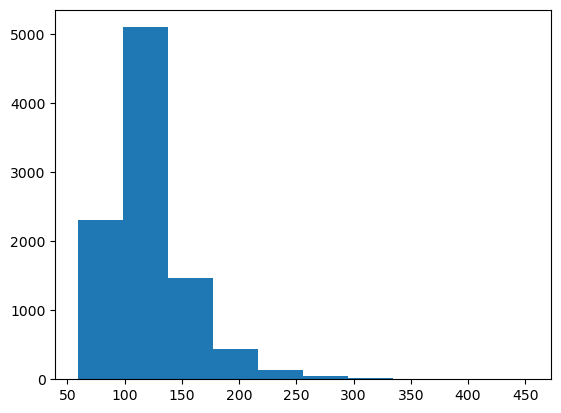

In [6]:
img_sizes = []
for gg in all_gals:
    mm, _, _ = gg['data']
    img_sizes.append(mm.shape[0])

plt.hist(img_sizes)
plt.show()

EFIGI 은하에 대해서 테스트 하는건 어떰? 

RandomCrop을 할 의미가 있을까?
은하의 중심이 어느정도 결정되어있고, 일부를 봐야하는 상황은 없으며, radial한 pattern이 중요한데. 
거기다가 은하별로 크기가 많이 차이나서 잘못하면 텅텅 빈 공간을 잘라오는 수가 있음. 

Rotation이랑 flip 정도만 말이 됨.


은하 말고 다른HDR 이미지에 톤맵해서 돌아가나 테스트해보기.

JPEG/PNG으로 한번 저장을 해보고, 바로 loading하는 경우랑 sanity check. Model마다 loader를 새로 쓰기는 귀찮으니. bnechmarking때 쓸모있을 것.

In [8]:
all_for_png = TonemapImageDataset(all_gals, partial(Mantiuk_Seidel, **tmo_params),
                                labels=cat['TT'].to_numpy(),
                                train=False, 
                                transform=None)

In [46]:
import os

In [56]:
ddir = "../../tonemap/bf_data/ImageDataset/Nair/"
if not os.path.isdir(ddir):
        os.mkdir(ddir)
        
for (im, _), cc in zip(all_for_png, cat.iterrows()):
    gid, tt, area = cc[1]['ID'], cc[1]['TT'], cc[1]['area']
    this_dir = ddir + f"{tt}/"
    if not os.path.isdir(this_dir):
        os.mkdir(this_dir)
    
    im.save(this_dir+f'{gid}.png')

In [45]:
cc[1]

ID      J235929.61p161009.65
TT                        -5
area                  347.54
Name: 3209, dtype: object

TT를 표준화해야하나? 
ID를 저장할 필요가 있을까? index를 다시 붙일까.

s = 1
color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
data_transforms = transforms.Compose([transforms.RandomResizedCrop(size=img_size),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomApply([color_jitter], p=0.8),
                                      transforms.RandomGrayscale(p=0.2),
                                      GaussianBlur(kernel_size=int(0.1 * img_size)),
                                      transforms.ToTensor(),
                                      transforms.Lambda(lambda x: x.mean(dim=0, keepdim=True))])
#if n_channels == 1:
#    _transform = _transform + [transforms.Lambda(lambda x: x.mean(dim=0, keepdim=True))]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8), 
    #transforms.RandomGrayscale(p=0.2), 
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.2])])#[0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])]) 

test_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.2])])#0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

## Split one chunk of dataset into train and test
#### Use torch.utils.data.random_split or [torch.utils.data.SubsetRandomSampler](https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets/50544887#50544887)

random_split takes a dataset -- for example, a tuple (tensor of data, tensor of label).  
SubsetRandomSampler is sent to a DataLoader as an optional argument. SubsetRandomSampler better suits to my case.

from torch.utils.data import SubsetRandomSampler

args.batch_size = 512
# data prepare
frac_train = 0.8

all_data = TonemapImageDatasetPair(all_gals, partial(Mantiuk_Seidel, **tmo_params),
                                     labels=cat['TT'].to_numpy(),
                                     train=True, 
                                     transform=train_transform)

all_data_val = TonemapImageDataset(all_gals, partial(Mantiuk_Seidel, **tmo_params),
                                     labels=cat['TT'].to_numpy(),
                                     train=False, 
                                     transform=test_transform)
len_data = len(all_data)

data_idx = np.arange(len_data)
np.random.shuffle(data_idx)
ind = int(np.floor(len_data * frac_train))
train_idx, test_idx = data_idx[:ind], data_idx[ind:]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = DataLoader(all_data, batch_size=args.batch_size, shuffle=False, num_workers=16, pin_memory=True, drop_last=True,
                         sampler=train_sampler)

test_loader = DataLoader(all_data_val, batch_size=args.batch_size, shuffle=False, num_workers=16, pin_memory=True, drop_last=True,
                         sampler=test_sampler)


In [7]:
class ResNetSimCLR(nn.Module):

    def __init__(self, base_model, out_dim):
        super(ResNetSimCLR, self).__init__()
        self.resnet_dict = {"resnet18": models.resnet18(pretrained=False, num_classes=out_dim, num_channels=1),
                            "resnet50": models.resnet50(pretrained=False, num_classes=out_dim, num_channels=1)}

        self.backbone = self._get_basemodel(base_model)
        dim_mlp = self.backbone.fc.in_features

        # add mlp projection head
        self.backbone.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.backbone.fc)

    def _get_basemodel(self, model_name):
        try:
            model = self.resnet_dict[model_name]
        except KeyError:
            raise InvalidBackboneError(
                "Invalid backbone architecture. Check the config file and pass one of: resnet18 or resnet50")
        else:
            return model

    def forward(self, x):
        return self.backbone(x)

In [8]:
import logging
import os
import sys
import yaml

import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
#from utils import save_config_file, accuracy, save_checkpoint



def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


def save_config_file(model_checkpoints_folder, args):
    if not os.path.exists(model_checkpoints_folder):
        os.makedirs(model_checkpoints_folder)
        with open(os.path.join(model_checkpoints_folder, 'config.yml'), 'w') as outfile:
            yaml.dump(args, outfile, default_flow_style=False)


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

class SimCLR(object):

    def __init__(self, *args, **kwargs):
        self.args = kwargs['args']
        self.model = kwargs['model'].to(self.args.device)
        self.optimizer = kwargs['optimizer']
        self.scheduler = kwargs['scheduler']
        self.writer = SummaryWriter()
        logging.basicConfig(filename=os.path.join(self.writer.log_dir, 'training.log'), level=logging.DEBUG)
        self.criterion = torch.nn.CrossEntropyLoss().to(self.args.device)

    def info_nce_loss(self, features):

        labels = torch.cat([torch.arange(self.args.batch_size) for i in range(self.args.n_views)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(self.args.device)

        features = F.normalize(features, dim=1)

        similarity_matrix = torch.matmul(features, features.T)
        # assert similarity_matrix.shape == (
        #     self.args.n_views * self.args.batch_size, self.args.n_views * self.args.batch_size)
        # assert similarity_matrix.shape == labels.shape

        # discard the main diagonal from both: labels and similarities matrix
        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(self.args.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
        # assert similarity_matrix.shape == labels.shape

        # select and combine multiple positives
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # select only the negatives the negatives
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.args.device)

        logits = logits / self.args.temperature
        return logits, labels

    def train(self, train_loader):

        scaler = GradScaler(enabled=self.args.fp16_precision)

        # save config file
        save_config_file(self.writer.log_dir, self.args)

        n_iter = 0
        logging.info(f"Start SimCLR training for {self.args.epochs} epochs.")
        logging.info(f"Training with gpu: {self.args.disable_cuda}.")

        for epoch_counter in range(self.args.epochs):
            for images, _ in tqdm(train_loader):
                images = torch.cat(images, dim=0)

                images = images.to(self.args.device)

                with autocast(enabled=self.args.fp16_precision):
                    features = self.model(images)
                    logits, labels = self.info_nce_loss(features)
                    loss = self.criterion(logits, labels)

                self.optimizer.zero_grad()

                scaler.scale(loss).backward()

                scaler.step(self.optimizer)
                scaler.update()

                if n_iter % self.args.log_every_n_steps == 0:
                    top1, top5 = accuracy(logits, labels, topk=(1, 5))
                    self.writer.add_scalar('loss', loss, global_step=n_iter)
                    self.writer.add_scalar('acc/top1', top1[0], global_step=n_iter)
                    self.writer.add_scalar('acc/top5', top5[0], global_step=n_iter)
                    self.writer.add_scalar('learning_rate', self.scheduler.get_lr()[0], global_step=n_iter)

                n_iter += 1

            # warmup for the first 10 epochs
            if epoch_counter >= 10:
                self.scheduler.step()
            logging.debug(f"Epoch: {epoch_counter}\tLoss: {loss}\tTop1 accuracy: {top1[0]}")

        logging.info("Training has finished.")
        # save model checkpoints
        checkpoint_name = 'checkpoint_{:04d}.pth.tar'.format(self.args.epochs)
        save_checkpoint({
            'epoch': self.args.epochs,
            'arch': self.args.arch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
        }, is_best=False, filename=os.path.join(self.writer.log_dir, checkpoint_name))
        logging.info(f"Model checkpoint and metadata has been saved at {self.writer.log_dir}.")

In [9]:
#def main():
#args = parser.parse_args()
assert args.n_views == 2, "Only two view training is supported. Please use --n-views 2."
# check if gpu training is available
if not args.disable_cuda and torch.cuda.is_available():
    args.device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    args.device = torch.device('cpu')
    args.gpu_index = -1

#dataset = ContrastiveLearningDataset(args.data)
#train_dataset = dataset.get_dataset(args.dataset_name, args.n_views)
def get_simclr_pipeline_transform(size, s=1, n_channels=3):
    """Return a set of data augmentation transformations as described in the SimCLR paper."""
    #color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
    _transforms = [transforms.RandomResizedCrop(size=size),
                  transforms.RandomHorizontalFlip(),
                  #transforms.RandomApply([color_jitter], p=0.8), <- 3 channel이어야만 사용 가능
                  #transforms.RandomGrayscale(p=0.2),
                  #GaussianBlur(kernel_size=int(0.1 * size)),
                  transforms.ToTensor()]
    if n_channels == 1:
        _transforms = _transforms + [transforms.Lambda(lambda x: x.mean(dim=0, keepdim=True))]

    return transforms.Compose(_transforms)

train_dataset = TonemapImageDataset(all_gals, partial(Mantiuk_Seidel, **tmo_params),
                                    labels=cat['TT'].to_numpy(),
                                    train=True, 
                                    transform=ContrastiveLearningViewGenerator(
                                        get_simclr_pipeline_transform(128, n_channels=1)
                                    ))


train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=True,
    num_workers=args.workers, pin_memory=True, drop_last=True)

model = ResNetSimCLR(base_model=args.arch, out_dim=args.out_dim)

optimizer = torch.optim.Adam(model.parameters(), args.lr, weight_decay=args.weight_decay)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0,
                                                       last_epoch=-1)


np.seterr(divide='ignore')
#  It’s a no-op if the 'gpu_index' argument is a negative integer or None.
with torch.cuda.device(args.gpu_index):
    simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, args=args)
    simclr.train(train_loader)
        
#main()

  0%|          | 0/298 [00:00<?, ?it/s]/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning: divide by zero encountered in log10
  lp = np.log10(lum) # L prime
/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  0%|          | 0/298 [00:00<?, ?it/s]/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning: divide by zero encountered in log10
  lp = np.log10(lum) # L prime
  0%|          | 0/298 [00:00<?, ?it/s]/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning: divide by zero encountered in log10
  lp = np.log10(lum) # L prime
  0%|          | 0/298 [00:00<?, ?it/s]/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning: divide by zero encountered in log10
  lp = np.log10(lum) # L prime
  0%|          | 0/298 

In [34]:
model

ResNetSimCLR(
  (backbone): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

## Q 
shuflle = False is forced because "sampler option is mutually exclusive with shuffle".  
Do I get different batches in different epochs? I want to train on different set of contrastive examples...   

## quick check images

In [35]:
from tqdm import tqdm
from torch.cuda.amp import autocast
feature_arr = []
for images, _ in tqdm(train_loader):
    images = torch.cat(images, dim=0)
    #images = images.to(args.device)


  0%|          | 0/37 [00:00<?, ?it/s]/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning: divide by zero encountered in log10
  lp = np.log10(lum) # L prime
  0%|          | 0/37 [00:00<?, ?it/s]


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 202, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-15-84df8faba3c0>", line 67, in __getitem__
    image = self.transform(image)
  File "<ipython-input-15-84df8faba3c0>", line 16, in __call__
    return [self.base_transform(x) for i in range(self.n_views)]
  File "<ipython-input-15-84df8faba3c0>", line 16, in <listcomp>
    return [self.base_transform(x) for i in range(self.n_views)]
  File "/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/torchvision/transforms/transforms.py", line 60, in __call__
    img = t(img)
  File "<ipython-input-7-4d808040457a>", line 39, in __call__
    img = self.blur(img)
  File "/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/torch/nn/modules/container.py", line 119, in forward
    input = module(input)
  File "/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/torch/nn/modules/conv.py", line 399, in forward
    return self._conv_forward(input, self.weight, self.bias)
  File "/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/torch/nn/modules/conv.py", line 395, in _conv_forward
    return F.conv2d(input, weight, bias, self.stride,
RuntimeError: Given groups=3, weight of size [3, 1, 13, 1], expected input[1, 1, 140, 140] to have 3 channels, but got 1 channels instead


center를 shift하지는 않는게 좋겠음. 

Batch size: 한 epoch에서 충분한 정보를 얻을 수 있어야 앞으로 나갈 수 있음. 얼만큼이 충분한지는 미리 알 방법이 없음. c

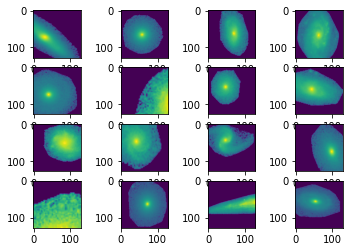

In [10]:
fig, axs = plt.subplots(4,4)
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.imshow(images[i][0])

#plt.tight_layout()
plt.show()

원래 예제 (CIPAR10)의 image 값 범위를 확인해볼 것. 

In [11]:
print("mean", images[1].mean(), "max", images[1].max(), "min", images[1].min())

mean tensor(-1.4847) max tensor(2.4412) min tensor(-2.5000)


#### Input 이미지는 문제 없어보임. 근데 왜 첫 loss 부터 nan이 나오는가? 

In [9]:
import importlib
importlib.reload(simclr)
importlib.reload(simclr.models)

<module 'atm.simclr.models' from '/home/hoseung/Work/ATM/atm/simclr/models.py'>

In [9]:
model = simclr.models.ResNetSimCLR(base_model=args.arch, out_dim=args.out_dim)

optimizer = torch.optim.Adam(model.parameters(), args.lr, weight_decay=args.wd)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0,
                                                           last_epoch=-1)

In [10]:
model.backbone

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

특정 배치에 있었던 이미지를 보려면?

loss는 쬐끔 줄어드려던 중이었음. weight가 explode한 듯? 

In [11]:
np.seterr(divide='ignore')

with torch.cuda.device(args.gpu_index):
    simc = simclr.models.SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, args=args)
    simc.train(train_loader) # model is saved at the end of train.

  0%|          | 0/14 [00:00<?, ?it/s]/home/hoseung/anaconda3/envs/tm39/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|          | 0/14 [00:02<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 11.77 GiB total capacity; 9.45 GiB already allocated; 210.00 MiB free; 9.67 GiB reserved in total by PyTorch)

In [17]:
np.seterr(divide='ignore')

with torch.cuda.device(args.gpu_index):
    simc = simclr.models.SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, args=args)
    simc.train(train_loader) # model is saved at the end of train.

  0%|          | 0/14 [00:00<?, ?it/s]

feature min max -0.614746 0.624023
current loss tensor(6.9046, device='cuda:0', grad_fn=<NllLossBackward>)


  7%|▋         | 1/14 [00:01<00:16,  1.27s/it]

feature min max -0.616699 0.629883
current loss tensor(6.8819, device='cuda:0', grad_fn=<NllLossBackward>)


 14%|█▍        | 2/14 [00:01<00:08,  1.38it/s]

feature min max -0.631348 0.643555
current loss tensor(6.9004, device='cuda:0', grad_fn=<NllLossBackward>)


 21%|██▏       | 3/14 [00:01<00:06,  1.82it/s]

feature min max -0.615723 0.62793
current loss tensor(6.9031, device='cuda:0', grad_fn=<NllLossBackward>)


 29%|██▊       | 4/14 [00:02<00:04,  2.14it/s]

feature min max -0.619629 0.630371
current loss tensor(6.8663, device='cuda:0', grad_fn=<NllLossBackward>)


 36%|███▌      | 5/14 [00:02<00:03,  2.37it/s]

feature min max -0.621582 0.633301
current loss tensor(6.8742, device='cuda:0', grad_fn=<NllLossBackward>)


 43%|████▎     | 6/14 [00:02<00:03,  2.52it/s]

feature min max -59.2188 52.4375
current loss tensor(6.9910, device='cuda:0', grad_fn=<NllLossBackward>)


 50%|█████     | 7/14 [00:03<00:02,  2.62it/s]

feature min max -526.0 498.0
current loss tensor(6.8321, device='cuda:0', grad_fn=<NllLossBackward>)


 57%|█████▋    | 8/14 [00:03<00:02,  2.69it/s]

feature min max -1271.0 1211.0
current loss tensor(6.7893, device='cuda:0', grad_fn=<NllLossBackward>)


 64%|██████▍   | 9/14 [00:04<00:01,  2.74it/s]

feature min max -2080.0 1982.0
current loss tensor(6.7055, device='cuda:0', grad_fn=<NllLossBackward>)


 71%|███████▏  | 10/14 [00:04<00:01,  2.78it/s]

feature min max -2794.0 2654.0
current loss tensor(6.7217, device='cuda:0', grad_fn=<NllLossBackward>)


 79%|███████▊  | 11/14 [00:04<00:01,  2.80it/s]

feature min max -3388.0 3212.0
current loss tensor(6.6837, device='cuda:0', grad_fn=<NllLossBackward>)


 86%|████████▌ | 12/14 [00:05<00:00,  2.82it/s]

feature min max -4020.0 3810.0
current loss tensor(6.5888, device='cuda:0', grad_fn=<NllLossBackward>)


 93%|█████████▎| 13/14 [00:05<00:00,  2.83it/s]

feature min max -4368.0 4152.0
current loss tensor(6.5025, device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/14 [00:00<?, ?it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


  7%|▋         | 1/14 [00:01<00:16,  1.28s/it]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 14%|█▍        | 2/14 [00:01<00:08,  1.37it/s]

feature min max -4660.0 4428.0
current loss tensor(6.5194, device='cuda:0', grad_fn=<NllLossBackward>)


 21%|██▏       | 3/14 [00:01<00:06,  1.80it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 29%|██▊       | 4/14 [00:02<00:04,  2.13it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 36%|███▌      | 5/14 [00:02<00:03,  2.36it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 43%|████▎     | 6/14 [00:02<00:03,  2.54it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 50%|█████     | 7/14 [00:03<00:02,  2.66it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 57%|█████▋    | 8/14 [00:03<00:02,  2.73it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 64%|██████▍   | 9/14 [00:04<00:01,  2.71it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 71%|███████▏  | 10/14 [00:04<00:01,  2.70it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 79%|███████▊  | 11/14 [00:04<00:01,  2.77it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 86%|████████▌ | 12/14 [00:05<00:00,  2.82it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 93%|█████████▎| 13/14 [00:05<00:00,  2.85it/s]

feature min max -inf inf
current loss tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>)


 93%|█████████▎| 13/14 [00:05<00:00,  2.24it/s]


KeyboardInterrupt: 

# representation quality check

## linear evaluation protocol, a standard way
Train a linear classifier on the fixed representations

## Load checkpoint

In [33]:
if True:
    checkpoint = torch.load('./runs/Aug23_00-13-48_hoseung/checkpoint_0300.pth.tar', map_location=args.device)
    state_dict = checkpoint['state_dict']
    
    resnet = simclr.models.ResNetSimCLR(base_model=args.arch, out_dim=args.out_dim)
    resnet.to(args.device)
    log = resnet.load_state_dict(state_dict, strict=False)

    print(log)
else:
    resnet = simc.model
    print("Using live simc instance")



<All keys matched successfully>


### Discard the projection head and leave the original backbone. 

In [21]:
# drop the projection head
resnet.backbone.fc = nn.Identity()

## t_SNE 

### Get features of the test set

test_transform에서 to_tensor해줬는데...??

### Test set Evaluation

In [34]:
from tqdm import tqdm
from torch.cuda.amp import autocast
feature_arr = []
for images, _ in tqdm(test_loader):
    #images = torch.cat(images, dim=0)
    images = images.to(args.device)

    # autocast <- AMP
    with autocast(enabled=args.fp16_precision):
        features = resnet.backbone(images)
        
    feature_arr.append(features.cpu().detach().numpy())

feature_arr = np.concatenate(feature_arr)

100%|██████████| 3/3 [00:01<00:00,  2.77it/s]


In [43]:
resnet.backbone.parameters()

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 2

In [68]:
b1 = resnet.backbone.layer4[0]

In [70]:
b1

Bottleneck(
  (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [72]:
b1.conv1.weight

Parameter containing:
tensor([[[[nan]],

         [[nan]],

         [[nan]],

         ...,

         [[nan]],

         [[nan]],

         [[nan]]],


        [[[nan]],

         [[nan]],

         [[nan]],

         ...,

         [[nan]],

         [[nan]],

         [[nan]]],


        [[[nan]],

         [[nan]],

         [[nan]],

         ...,

         [[nan]],

         [[nan]],

         [[nan]]],


        ...,


        [[[nan]],

         [[nan]],

         [[nan]],

         ...,

         [[nan]],

         [[nan]],

         [[nan]]],


        [[[nan]],

         [[nan]],

         [[nan]],

         ...,

         [[nan]],

         [[nan]],

         [[nan]]],


        [[[nan]],

         [[nan]],

         [[nan]],

         ...,

         [[nan]],

         [[nan]],

         [[nan]]]], device='cuda:0', requires_grad=True)

In [21]:
from sklearn.manifold import TSNE

In [54]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feature_arr)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
# 2D projection of 1024(?)-dim features
tsne = TSNE(n_components=2).fit_transform(features)


In [11]:
optimizer = torch.optim.Adam(resnet.parameters(), lr=3e-4, weight_decay=0.0008)
criterion = torch.nn.CrossEntropyLoss().to(args.device)

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [12]:
from torch.utils.data import DataLoader
def get_cifar10_data_loaders(download, shuffle=False, batch_size=256):
    train_dataset = torchvision.datasets.CIFAR10('./data', train=True, download=download,
                                  transform=transforms.ToTensor())

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            num_workers=0, drop_last=False, shuffle=shuffle)

    test_dataset = torchvision.datasets.CIFAR10('./data', train=False, download=download,
                                  transform=transforms.ToTensor())

    test_loader = DataLoader(test_dataset, batch_size=2*batch_size,
                            num_workers=10, drop_last=False, shuffle=shuffle)
    return train_loader, test_loader

train_loader, test_loader = get_cifar10_data_loaders(download=True)
# num_workers=0. Using multiple (even num_workers=1) causes an error 'can only test a child process'.

Files already downloaded and verified
Files already downloaded and verified


In [120]:
epochs = 100
for epoch in range(epochs):
    top1_train_accuracy = 0
    for counter, (x_batch,y_batch) in enumerate(train_loader):
        x_batch = x_batch.to(args.device)
        y_batch = y_batch.to(args.device)
        
        logits = resnet(x_batch)
        loss = criterion(logits, y_batch)
        top1 = accuracy(logits, y_batch, topk=(1,))
        top1_train_accuracy += top1[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    top1_train_accuracy /= (counter + 1)
    top1_accuracy = 0
    top5_accuracy = 0
    for counter, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.to(args.device)
        y_batch = y_batch.to(args.device)

        logits = resnet(x_batch)

        top1, top5 = accuracy(logits, y_batch, topk=(1,5))
        top1_accuracy += top1[0]
        top5_accuracy += top5[0]

    top1_accuracy /= (counter + 1)
    top5_accuracy /= (counter + 1)
    print(f"Epoch {epoch}\tTop1 Train accuracy {top1_train_accuracy.item()}\tTop1 Test accuracy: {top1_accuracy.item()}\tTop5 test acc: {top5_accuracy.item()}")

KeyboardInterrupt: 

In [ ]:
class SimCLRClassifier(nn.Module):
    def __init__(self, base_model, freeze_base, base_feature_size=512, n_views=2):
        self.embeddings = base_model
        
        if freeze_base:
            print("Freezing embeddings")
            for param in self.embeddings.parameters():
                param.requires_grad = False
                
        self.classifier = nn.Linear(in_features = base_feature_size, 
                                   out_features = n_views) #
    
    def forward(self, X, *args):
        emb = self.embeddings(X)
        return self.classifier(emb)
    
class SimCLRClassifierModule

In [63]:
from sklearn.metrics import classification_report

In [ ]:
def evaluate(data_loader, module):
    with torch.no_grad():
        progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
        module.eval().cuda()
        true_y, pred_y = [], []
        for i, batch_ in enumerate(data_loader):
            X, y = batch_
            print(progress[i % len(progress)], end="\r")
            y_pred = torch.argmax(module(X.cuda()), dim=1)
            true_y.extend(y.cpu())
            pred_y.extend(y_pred.cpu())
        print(classification_report(true_y, pred_y, digits=3))
        return true_y, pred_y

_ = evaluate(module.val_dataloader(), module)